In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
from keras.utils import to_categorical
import os
import pandas as pd
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
K.set_image_data_format('channels_first')
config = tf.ConfigProto( device_count = {'CPU': 1} ) 
sess = tf.Session(config=config) 
K.set_session(sess)

In [3]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [28]:
def plot_history(history):
    plt.figure(figsize=(15,3))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim([0,1])
    plt.legend(['train', 'validate'], loc='lower right')

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper right')
    plt.show()

def print_classification(X_val, y_val, X_test, y_test, only_cm=False):
    
    y_test_pred = np.argmax(model.predict(X_test), axis=1)
    y_test_target = np.argmax(y_test, axis=1)
    
    y_val_pred = np.argmax(model.predict(X_val), axis=1)
    y_val_target = np.argmax(y_val, axis=1)
    
    target_names = ['MT1', 'MT3']

    if not only_cm:
        print('Classification Report validation')
        print(classification_report(y_val_target, y_val_pred, target_names=target_names))
        print('Classification Report testing')
        print(classification_report(y_test_target, y_test_pred, target_names=target_names))

    cm_test = confusion_matrix(y_test_target, y_test_pred)
    cm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
    df_cm_test = pd.DataFrame(cm_test, index = target_names, columns = target_names)
    
    cm_val = confusion_matrix(y_val_target, y_val_pred)
    cm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
    df_cm_val = pd.DataFrame(cm_val, index = target_names, columns = target_names)

    plt.figure(figsize = (20,6))
    plt.subplot(1,2,1)
    sn.heatmap(df_cm_val, annot=True)
    plt.ylim(-0.5, 2);
    plt.subplot(1,2,2)
    sn.heatmap(df_cm_test, annot=True)
    plt.ylim(-0.5, 2);

## Creating Datasets

In [5]:
def normalize(signal):
    x = signal - signal.mean()
    x /= x.std()
    x /= x.max()
    return x

def denormalize(train, mean, std, max):
    return train*max*std+mean

### load real samples

In [6]:
mts_real = np.load('/s/chopin/d/proj/jcuomo/mentaltask/mental_tasks_7.npy')

mt1_real = normalize(mts_real[:,0])
mt3_real = normalize(mts_real[:,2])

mt1_real_y = np.ones(len(mt1_real))*0
mt3_real_y = np.ones(len(mt3_real))*1

In [7]:
X_real = np.vstack((mt1_real, mt3_real))
X_real = np.expand_dims(X_real,1)
X_real = X_real.astype('float32')
y_real = np.hstack((mt1_real_y, mt3_real_y))
y_real_binary = to_categorical(y_real)

X_real.shape, y_real.shape, y_real_binary.shape

((96, 1, 1536, 8), (96,), (96, 2))

### load testing samples

In [8]:
mts_tune = np.load('/s/chopin/d/proj/jcuomo/mentaltask/mental_tasks_8_1trial.npy')

mt1_tune = normalize(mts_tune[:,0])
mt3_tune = normalize(mts_tune[:,2])

mt1_tune_y = np.ones(len(mt1_tune))*0
mt3_tune_y = np.ones(len(mt3_tune))*1


In [9]:
X_tune = np.vstack((mt1_tune, mt3_tune))
X_tune = np.expand_dims(X_tune,1)
X_tune = X_tune.astype('float32')
y_tune = np.hstack((mt1_tune_y, mt3_tune_y))
y_tune = to_categorical(y_tune)

X_tune.shape, y_tune.shape

((2, 1, 1536, 8), (2, 2))

In [10]:
mts_test = np.load('/s/chopin/d/proj/jcuomo/mentaltask/mental_tasks_8_5trial.npy')

mt1_test = normalize(mts_test[:,0])
mt3_test = normalize(mts_test[:,2])

mt1_test_y = np.ones(len(mt1_test))*0
mt3_test_y = np.ones(len(mt3_test))*1


In [11]:
X_test = np.vstack((mt1_test, mt3_test))
X_test = np.expand_dims(X_test,1)
X_test = X_test.astype('float32')
y_test = np.hstack((mt1_test_y, mt3_test_y))
y_test = to_categorical(y_test)

X_test.shape, y_test.shape

((10, 1, 1536, 8), (10, 2))

### load fake samples

In [21]:
N_fake = 100

mt1_fake = np.load('/s/chopin/d/proj/jcuomo/mentaltask/mt1_fake.npy')[:N_fake]
mt3_fake = np.load('/s/chopin/d/proj/jcuomo/mentaltask/mt3_fake.npy')[:N_fake]

mt1_fake_y = np.ones(len(mt1_fake))*0
mt3_fake_y = np.ones(len(mt3_fake))*1


In [22]:
X_fake = np.vstack((mt1_fake, mt3_fake))
X_fake = np.expand_dims(X_fake,1)
X_fake = X_fake.astype('float32')
y_fake = np.hstack((mt1_fake_y, mt3_fake_y))
y_fake_binary = to_categorical(y_fake)

X_fake.shape, y_fake.shape, y_fake_binary.shape

((200, 1, 1536, 8), (200,), (200, 2))

### split a part of real samples for testing

In [14]:
X_train_real, X_val, y_train_real, y_val = train_test_split(X_real, y_real_binary, test_size=0.2, shuffle=True)
X_train_real.shape, y_train_real.shape, X_val.shape, y_val.shape

((76, 1, 1536, 8), (76, 2), (20, 1, 1536, 8), (20, 2))

### merge fake samples with training part of real samples

In [23]:
X_train = np.vstack((X_train_real, X_fake))
y_train = np.vstack((y_train_real, y_fake_binary))

In [16]:
X_train = np.swapaxes(X_train,2,3)
X_test = np.swapaxes(X_test,2,3)
X_tune = np.swapaxes(X_tune,2,3)
X_val = np.swapaxes(X_val,2,3)
X_train.shape, y_train.shape

((78, 1, 8, 1536), (78, 2))

In [25]:
X_train = np.swapaxes(X_train,2,3)

## Creating the model

In [17]:
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):

    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1       = Input(shape = (1, Chans, Samples))

    block1       = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = (1, Chans, Samples), use_bias = False)(input1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16), use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization(axis = 1)(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

In [18]:
model = EEGNet(nb_classes = 2, Chans = 8, Samples = 1536)
model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
#tf.keras.utils.plot_model(model, show_shapes=1)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Train the model

In [26]:
X_val.shape, y_val.shape, X_test.shape, y_test.shape, X_train.shape, y_train.shape

((20, 1, 8, 1536),
 (20, 2),
 (10, 1, 8, 1536),
 (10, 2),
 (276, 1, 8, 1536),
 (276, 2))

### not augmented

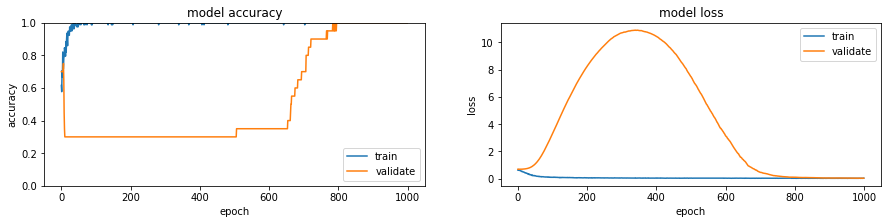

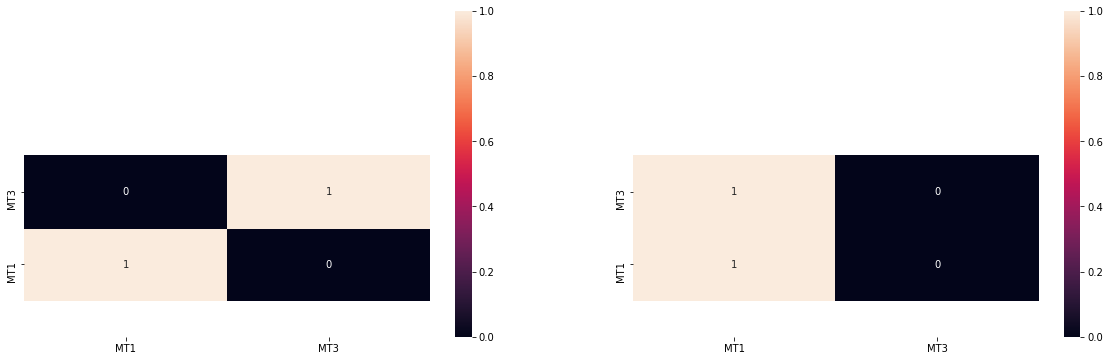

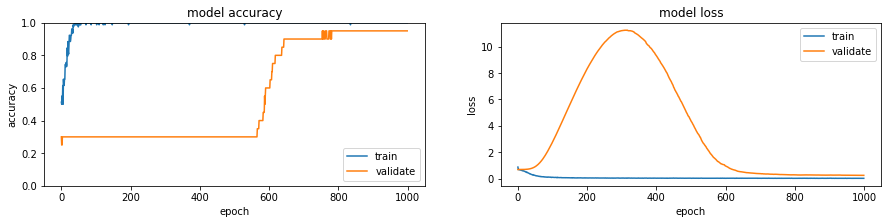

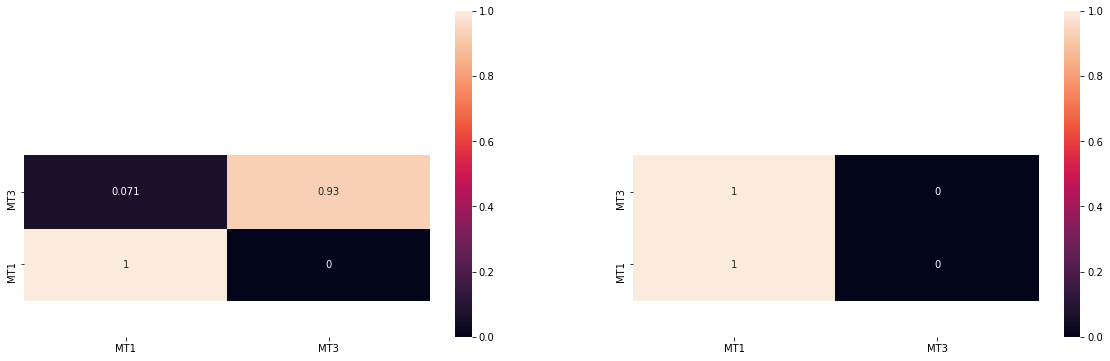

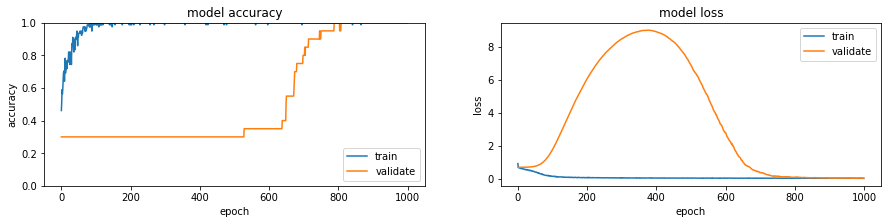

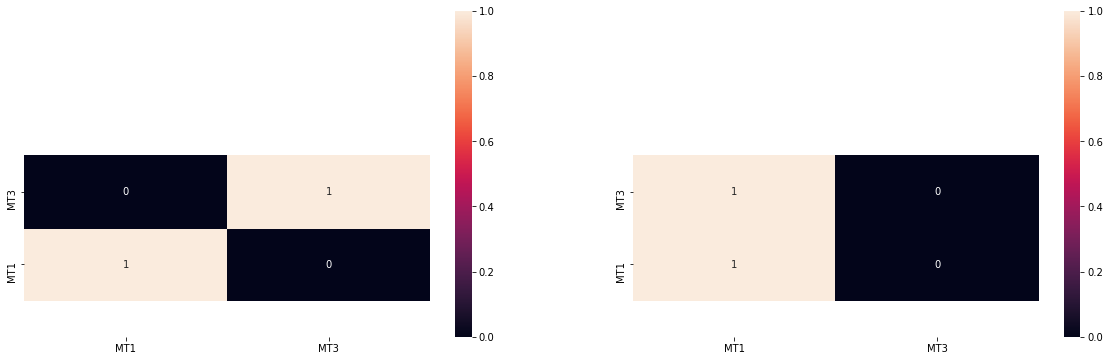

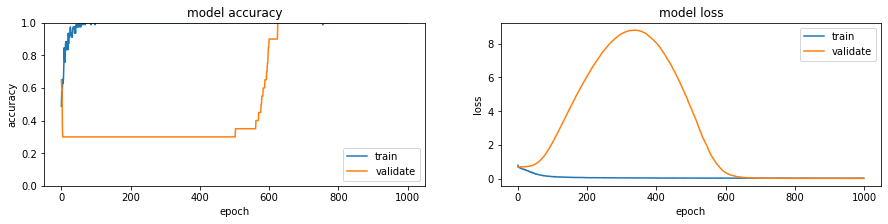

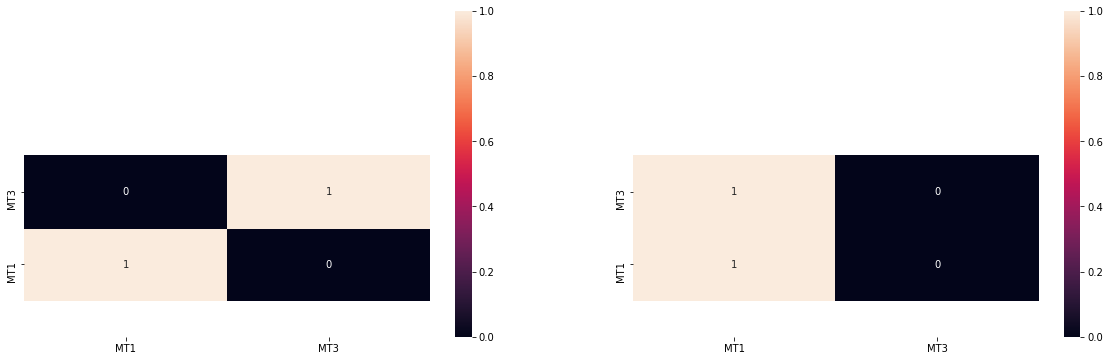

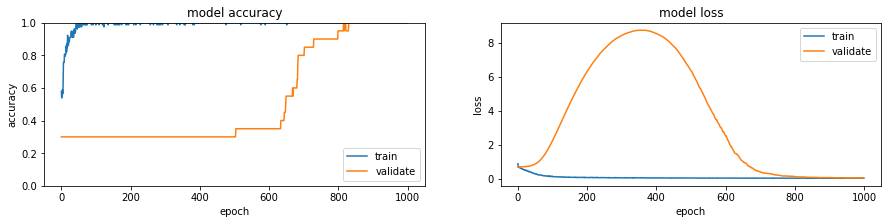

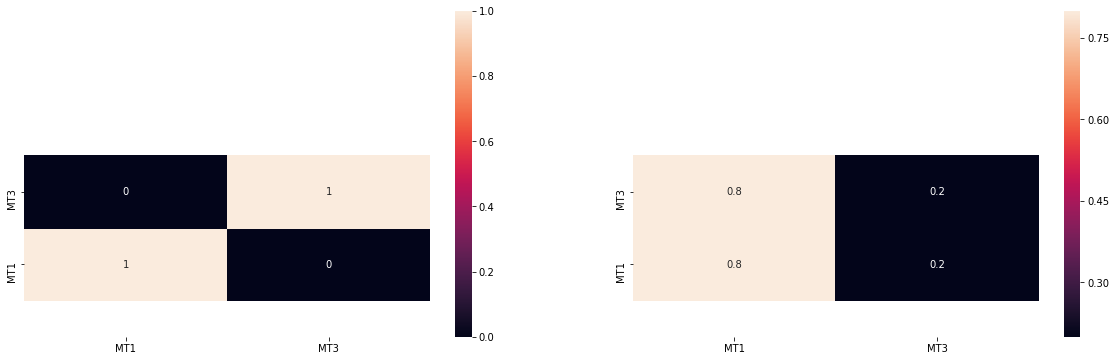

In [20]:
for i in range(5):
    model = EEGNet(nb_classes = 2, Chans = 8, Samples = 1536)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
    history = model.fit(X_train, y_train,batch_size=256,epochs=1000,validation_data=(X_val, y_val), verbose=False)
    plot_history(history)
    print_classification(X_val, y_val, X_test, y_test, only_cm=True)

### augmented

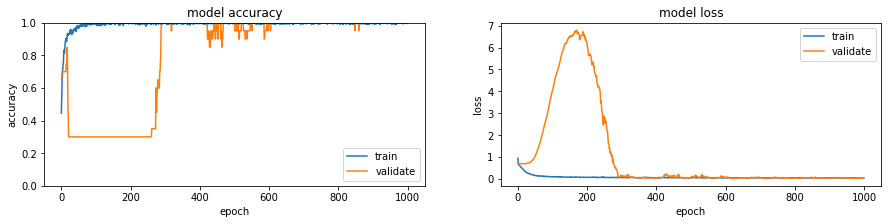

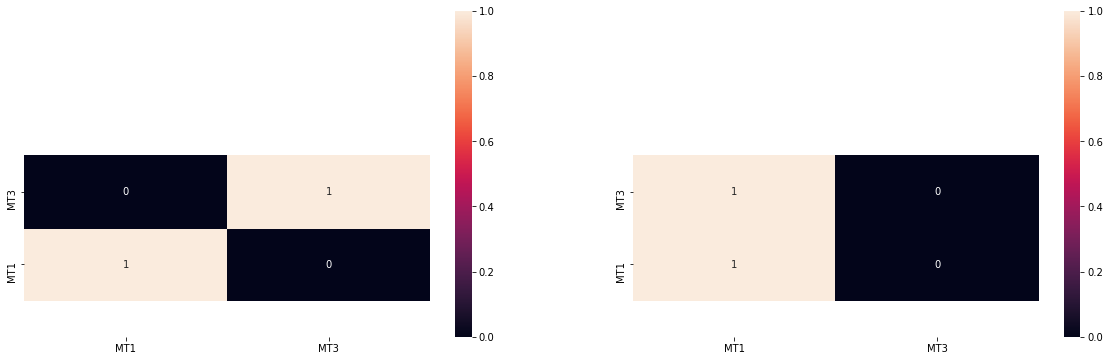

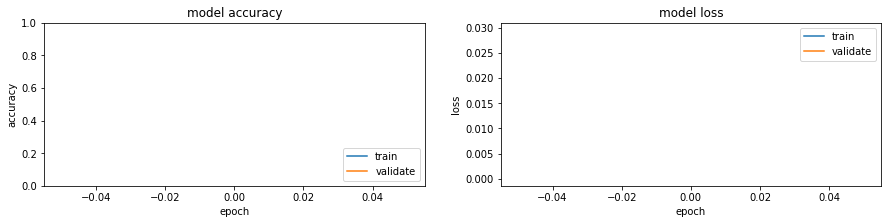

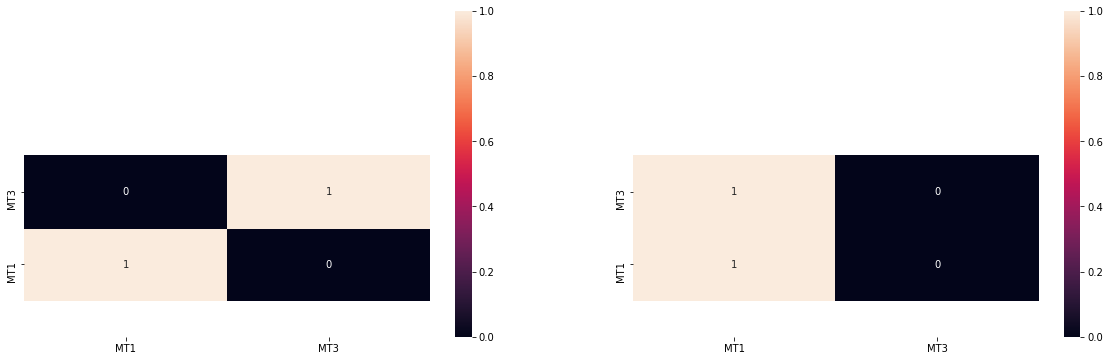

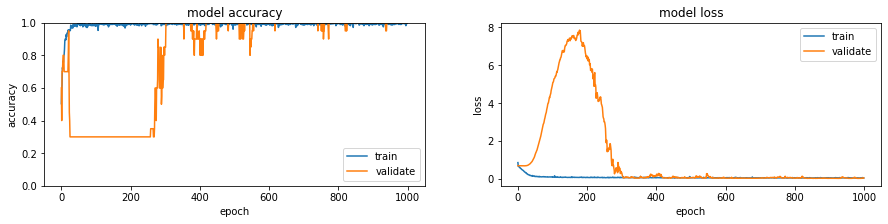

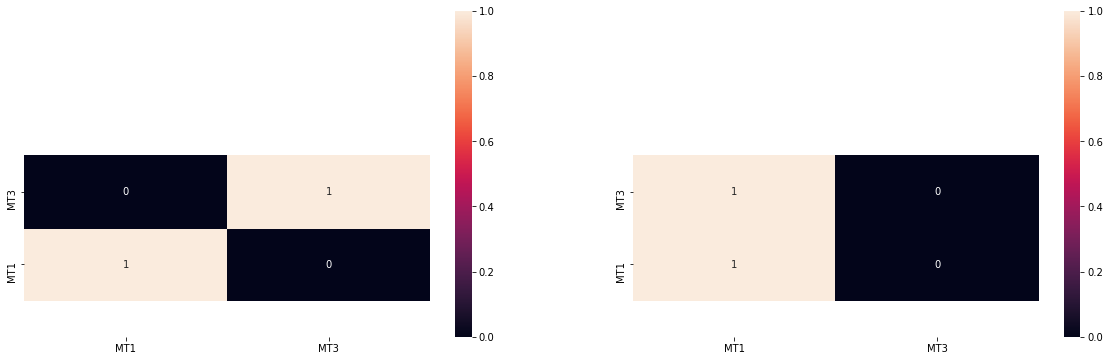

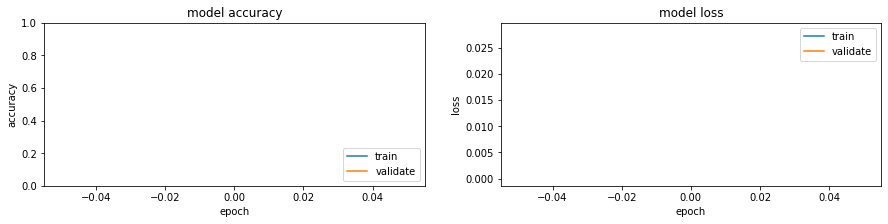

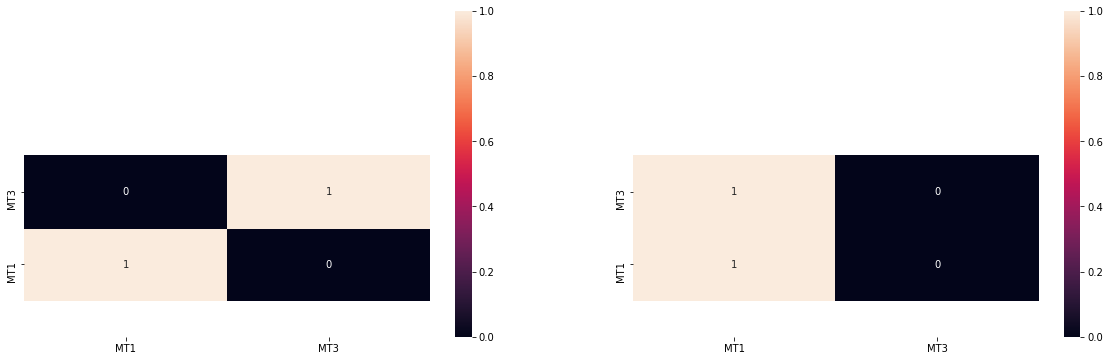

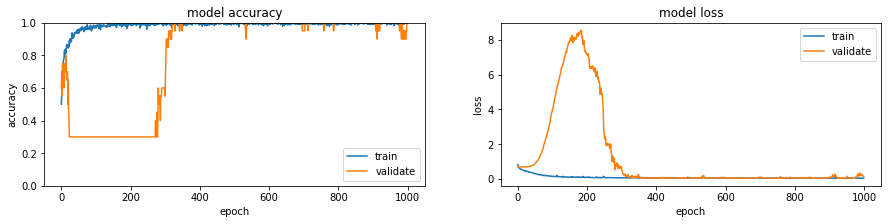

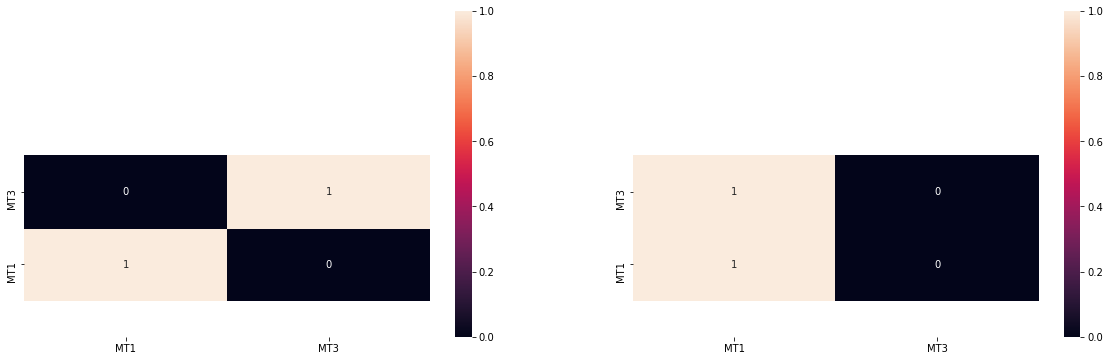

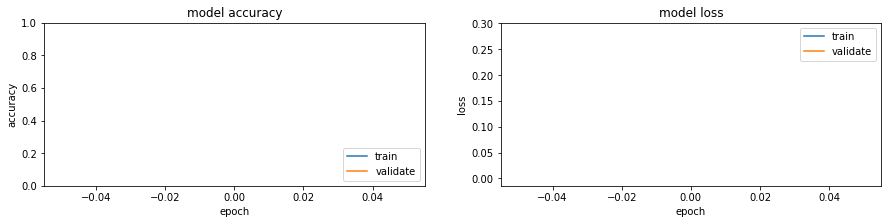

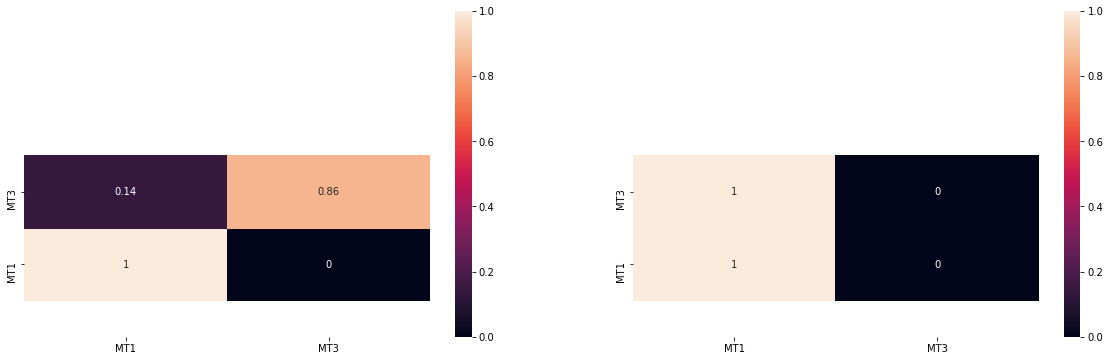

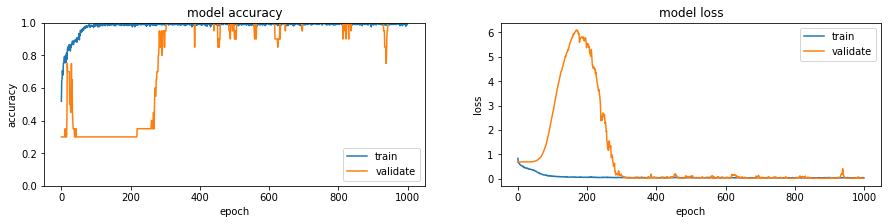

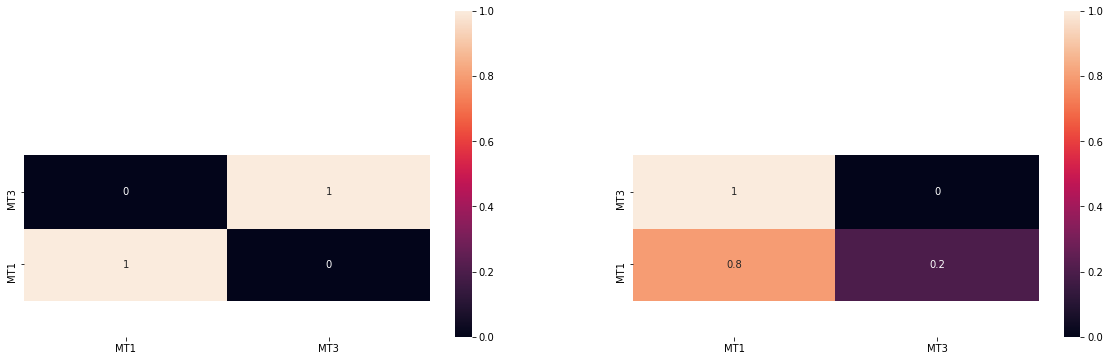

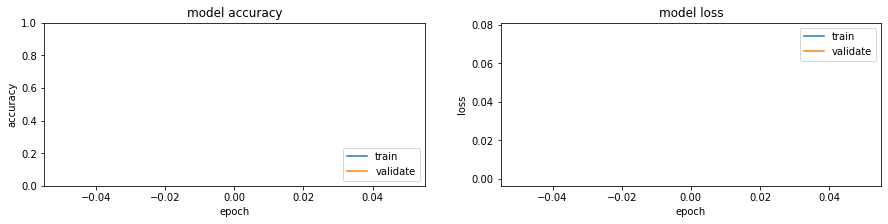

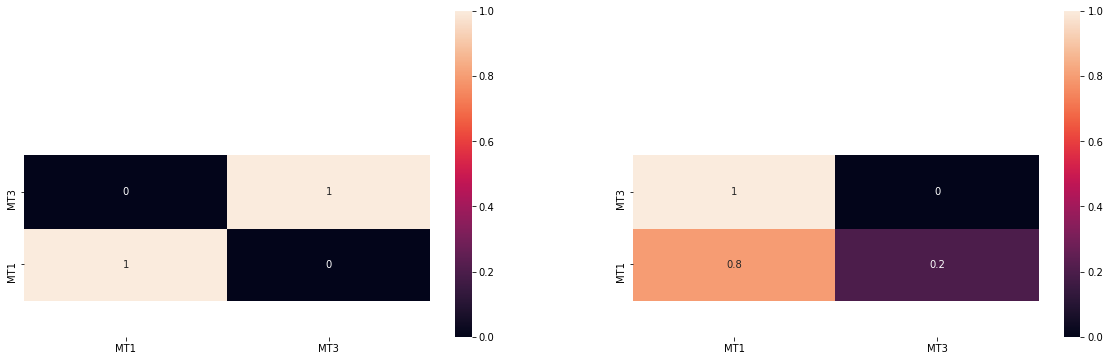

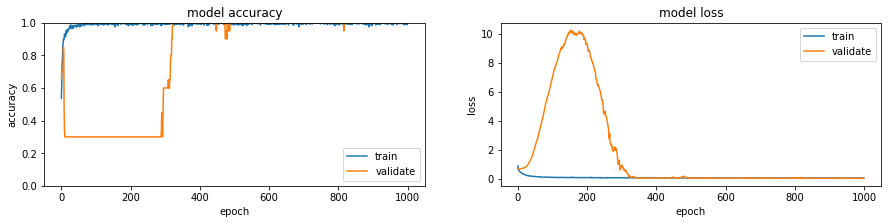

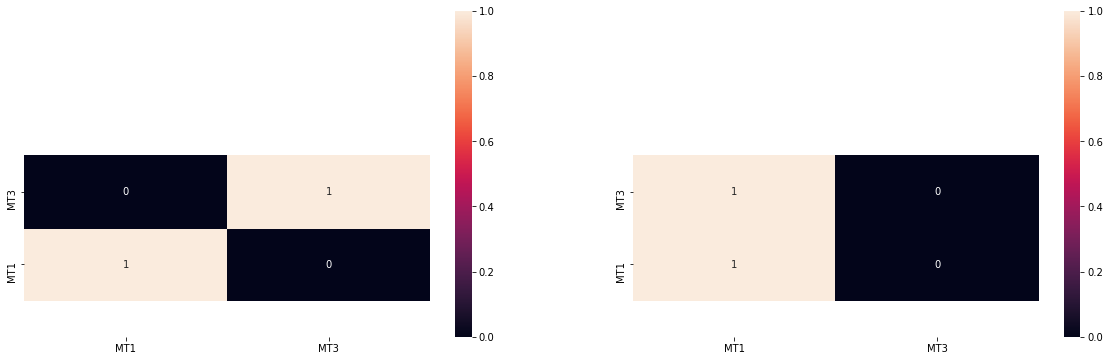

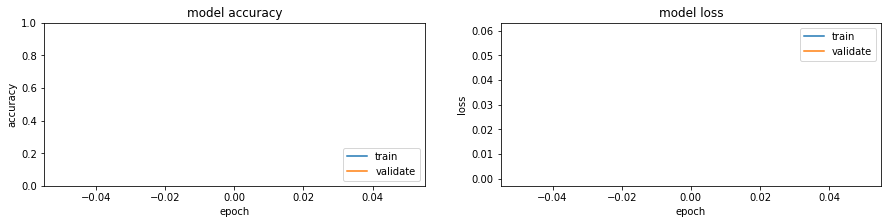

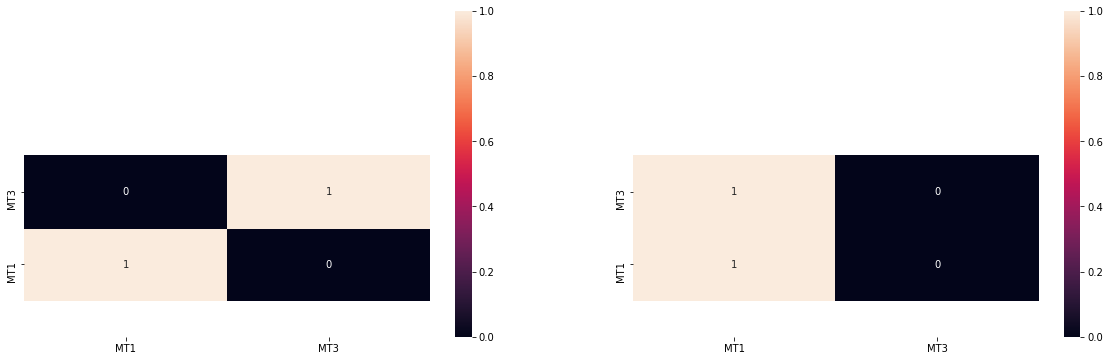

In [27]:
for i in range(5):
    model = EEGNet(nb_classes = 2, Chans = 8, Samples = 1536)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
    history = model.fit(X_train, y_train,batch_size=256,epochs=1000,validation_data=(X_val, y_val), verbose=False)
    plot_history(history)
    print_classification(X_val, y_val, X_test, y_test, only_cm=True)
    history = model.fit(X_tune, y_tune,batch_size=256,epochs=1,validation_data=(X_val, y_val), verbose=False)
    plot_history(history)
    print_classification(X_val, y_val, X_test, y_test, only_cm=True)   

## statistical analysis

In [ ]:
trials = 100
cms = np.zeros((trials,2,2))

for i in range(trials):
    non_p300 = np.load('/s/chopin/d/proj/jcuomo/non_p300_ch_filtered.npy')[:540]
    std_non_p300 = non_p300.std(axis=0)
    mean_non_p300 = non_p300.mean(axis=0)
    non_p300 = normalize(non_p300)
    non_p300_target = np.zeros(len(non_p300))

    p300 = np.load('/s/chopin/d/proj/jcuomo/p300_ch_filtered.npy')
    std_p300 = p300.std(axis=0)
    mean_p300 = p300.mean(axis=0)
    p300 = normalize(p300)
    p300_target = np.ones(len(p300))

    X = np.vstack((non_p300, p300))
    X = np.expand_dims(X,1)
    X = X.astype('float32')
    y = np.hstack((non_p300_target, p300_target))
    y_binary = to_categorical(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.5, shuffle=True)



    model  = EEGNet(nb_classes = 2, Chans = 8, Samples = 192)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
    history = model.fit(X_train, y_train,batch_size=256,epochs=500,validation_data=(X_test, y_test),verbose=0)
    
    Y_pred  = model.predict(X_test)
    y_pred_ = np.argmax(Y_pred, axis=1)
    y_test_ = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_test_, y_pred_)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cms[i] = cm

target_names = ['letter', 'not letter']
mean_cm = cms.mean(0)
std_cm = cms.std(0)
df_mean = pd.DataFrame(mean_cm, index = target_names, columns = target_names)
df_std  = pd.DataFrame(std_cm, index = target_names, columns = target_names)
labels =  np.array([["{:.2f} \u00B1 {:.2f}".format(mean_cm[0,0],std_cm[0,0]),
                     "{:.2f} \u00B1 {:.2f}".format(mean_cm[0,1],std_cm[0,1])],
                    ["{:.2f} \u00B1 {:.2f}".format(mean_cm[1,0],std_cm[1,0]),
                     "{:.2f} \u00B1 {:.2f}".format(mean_cm[1,1],std_cm[1,1])]])
ax = sn.heatmap(df_mean, annot = labels, fmt = '', vmin = 0, vmax = 1, annot_kws={"size": 15})
plt.ylim(-0.5, 2);

In [ ]:
trials = 100
cms = np.zeros((trials,2,2))

for i in range(trials):
    non_p300 = np.load('/s/chopin/d/proj/jcuomo/non_p300_ch_filtered.npy')[:540]
    std_non_p300 = non_p300.std(axis=0)
    mean_non_p300 = non_p300.mean(axis=0)
    non_p300 = normalize(non_p300)
    non_p300_target = np.zeros(len(non_p300))

    p300 = np.load('/s/chopin/d/proj/jcuomo/p300_ch_filtered.npy')
    std_p300 = p300.std(axis=0)
    mean_p300 = p300.mean(axis=0)
    p300 = normalize(p300)
    p300_target = np.ones(len(p300))

    X = np.vstack((non_p300, p300))
    X = np.expand_dims(X,1)
    X = X.astype('float32')
    y = np.hstack((non_p300_target, p300_target))
    y_binary = to_categorical(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.5, shuffle=True)

    N_fake = 500

    #fake_non_p300 = np.load('fake_non_target.npy')[:250]
    fake_non_p300 = np.load('/s/chopin/d/proj/jcuomo/non_p300_ch_filtered.npy')[540:540+N_fake]
    fake_non_p300 = normalize(fake_non_p300)
    fake_non_p300 = np.expand_dims(fake_non_p300,1)
    #fake_non_p300 = np.swapaxes(fake_non_p300,2,3)

    #fake_p300 = np.load('fake_target.npy')[:400]
    fake_p300 = np.load('/s/chopin/d/proj/jcuomo/p300_fake.npy')[:N_fake]
    fake_p300 = normalize(fake_p300)
    #fake_p300 = denormalize(fake_p300, mean=0.6423540552419914, std=9.69371259673719, max=10.735539759779167)
    #fake_p300 = denormalize2(fake_p300, std_p300.T, mean_p300.T)
    fake_p300 = np.swapaxes(fake_p300,2,3)
    fake_non_p300.shape, fake_p300.shape

    X_fake = np.vstack((fake_non_p300, fake_p300)).astype('float32')

    fake_non_p300_y = np.zeros(len(fake_non_p300))
    fake_p300_y = np.ones(len(fake_p300))
    y_fake = np.hstack((fake_non_p300_y, fake_p300_y))
    y_fake_binary = to_categorical(y_fake)

    X_train = np.vstack((X_train, X_fake))
    y_train = np.vstack((y_train, y_fake_binary))
    
    model  = EEGNet(nb_classes = 2, Chans = 8, Samples = 192)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
    history = model.fit(X_train, y_train,batch_size=256,epochs=500,validation_data=(X_test, y_test),verbose=0)
    
    Y_pred  = model.predict(X_test)
    y_pred_ = np.argmax(Y_pred, axis=1)
    y_test_ = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_test_, y_pred_)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cms[i] = cm

target_names = ['letter', 'not letter']
mean_cm = cms.mean(0)
std_cm = cms.std(0)
df_mean = pd.DataFrame(mean_cm, index = target_names, columns = target_names)
df_std  = pd.DataFrame(std_cm, index = target_names, columns = target_names)
labels =  np.array([["{:.2f} \u00B1 {:.2f}".format(mean_cm[0,0],std_cm[0,0]),
                     "{:.2f} \u00B1 {:.2f}".format(mean_cm[0,1],std_cm[0,1])],
                    ["{:.2f} \u00B1 {:.2f}".format(mean_cm[1,0],std_cm[1,0]),
                     "{:.2f} \u00B1 {:.2f}".format(mean_cm[1,1],std_cm[1,1])]])
ax = sn.heatmap(df_mean, annot = labels, fmt = '', vmin = 0, vmax = 1, annot_kws={"size": 15})
plt.ylim(-0.5, 2);

## gen4 real

In [ ]:
def normalize(signal):
    x = signal - signal.mean()
    x /= x.std()
    x /= x.max()
    return x

In [ ]:
def cm(X_val, y_val, cm_val, cm_test, i, model):
    
    # val
    Y_pred  = model.predict(X_val)
    y_pred_ = np.argmax(Y_pred, axis=1)
    y_val_ = np.argmax(y_val, axis=1)

    cm = confusion_matrix(y_val_, y_pred_)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cms_val[i] = cm
    
    
    # test
    p300 = np.load('/s/chopin/d/proj/jcuomo/p300_test_filt.npy')
    p300 = normalize(p300)
    p300_target = np.ones(len(p300))

    non_p300 = np.load('/s/chopin/d/proj/jcuomo/non_p300_test_filt.npy')[:len(p300)]
    non_p300 = normalize(non_p300)
    non_p300_target = np.zeros(len(non_p300))

    X = np.vstack((non_p300, p300))
    X = np.expand_dims(X,1)
    X_test = X.astype('float32')
    y = np.hstack((non_p300_target, p300_target))
    y_test = to_categorical(y)


    Y_pred  = model.predict(X_test)
    y_pred_ = np.argmax(Y_pred, axis=1)
    y_test_ = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_test_, y_pred_)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cms_test[i] = cm
    
    return cms_val, cms_test

def plot_cms(cms):
    plt.figure()
    target_names = ['letter', 'not letter']
    mean_cm = cms.mean(0)
    std_cm = cms.std(0)
    df_mean = pd.DataFrame(mean_cm, index = target_names, columns = target_names)
    df_std  = pd.DataFrame(std_cm, index = target_names, columns = target_names)
    labels =  np.array([["{:.2f} \u00B1 {:.2f}".format(mean_cm[0,0],std_cm[0,0]),
                         "{:.2f} \u00B1 {:.2f}".format(mean_cm[0,1],std_cm[0,1])],
                        ["{:.2f} \u00B1 {:.2f}".format(mean_cm[1,0],std_cm[1,0]),
                         "{:.2f} \u00B1 {:.2f}".format(mean_cm[1,1],std_cm[1,1])]])
    ax = sn.heatmap(df_mean, annot = labels, fmt = '', vmin = 0, vmax = 1, annot_kws={"size": 15})
    plt.ylim(-0.5, 2);

In [ ]:
trials = 50
cms_val = np.zeros((trials,2,2))
cms_test = np.zeros((trials,2,2))

for i in range(trials):
    p300 = np.load('/s/chopin/d/proj/jcuomo/p300_train_filt.npy')
    std_p300 = p300.std(axis=0)
    mean_p300 = p300.mean(axis=0)
    p300 = normalize(p300)
    p300_target = np.ones(len(p300))

    
    non_p300 = np.load('/s/chopin/d/proj/jcuomo/non_p300_train_filt.npy')[:len(p300)]
    std_non_p300 = non_p300.std(axis=0)
    mean_non_p300 = non_p300.mean(axis=0)
    non_p300 = normalize(non_p300)
    non_p300_target = np.zeros(len(non_p300))

    
    X = np.vstack((non_p300, p300))
    X = np.expand_dims(X,1)
    X = X.astype('float32')
    y = np.hstack((non_p300_target, p300_target))
    y_binary = to_categorical(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.8, shuffle=True)


    model  = EEGNet(nb_classes = 2, Chans = 8, Samples = 192)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
    history = model.fit(X_train, y_train,batch_size=256,epochs=500, validation_data=(X_test, y_test),verbose=0)
    
    cms_val, cms_test = cm(X_test, y_test, cms_val, cms_test, i, model)
    
plot_cms(cms_val)
plt.title("Validation")

plt.title("Test")
plot_cms(cms_test)

print("Train samples:", X_train.shape[0], ", test samples:", X_test.shape[0])    

## gen4 augmented

In [ ]:
trials = 50
cms_val = np.zeros((trials,2,2))
cms_test = np.zeros((trials,2,2))

for i in range(trials):

    p300 = np.load('/s/chopin/d/proj/jcuomo/p300_ch_filtered.npy')
    std_p300 = p300.std(axis=0)
    mean_p300 = p300.mean(axis=0)
    p300 = normalize(p300)
    p300_target = np.ones(len(p300))

    non_p300 = np.load('/s/chopin/d/proj/jcuomo/non_p300_train_filt.npy')[:len(p300)]
    std_non_p300 = non_p300.std(axis=0)
    mean_non_p300 = non_p300.mean(axis=0)
    non_p300 = normalize(non_p300)
    non_p300_target = np.zeros(len(non_p300))
    
    X = np.vstack((non_p300, p300))
    X = np.expand_dims(X,1)
    X = X.astype('float32')
    y = np.hstack((non_p300_target, p300_target))
    y_binary = to_categorical(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.5, shuffle=True)

    N_fake = len(p300)

    #fake_non_p300 = np.load('fake_non_target.npy')[:250]
    fake_non_p300 = np.load('/s/chopin/d/proj/jcuomo/non_p300_train_filt.npy')[len(p300):len(p300)+N_fake]
    fake_non_p300 = normalize(fake_non_p300)
    fake_non_p300 = np.expand_dims(fake_non_p300,1)
    #fake_non_p300 = np.swapaxes(fake_non_p300,2,3)

    #fake_p300 = np.load('fake_target.npy')[:400]
    fake_p300 = np.load('/s/chopin/d/proj/jcuomo/p300_fake4.npy')[:N_fake]
    fake_p300 = normalize(fake_p300)
    #fake_p300 = denormalize(fake_p300, mean=0.6423540552419914, std=9.69371259673719, max=10.735539759779167)
    #fake_p300 = denormalize2(fake_p300, std_p300.T, mean_p300.T)
    fake_p300 = np.swapaxes(fake_p300,2,3)
    fake_non_p300.shape, fake_p300.shape

    X_fake = np.vstack((fake_non_p300, fake_p300)).astype('float32')

    fake_non_p300_y = np.zeros(len(fake_non_p300))
    fake_p300_y = np.ones(len(fake_p300))
    y_fake = np.hstack((fake_non_p300_y, fake_p300_y))
    y_fake_binary = to_categorical(y_fake)

    X_train = np.vstack((X_train, X_fake))
    y_train = np.vstack((y_train, y_fake_binary))
    
    model  = EEGNet(nb_classes = 2, Chans = 8, Samples = 192)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
    history = model.fit(X_train, y_train,batch_size=256,epochs=500,validation_data=(X_test, y_test),verbose=0)
    
    Y_pred  = model.predict(X_test)
    y_pred_ = np.argmax(Y_pred, axis=1)
    y_test_ = np.argmax(y_test, axis=1)

    cms_val, cms_test = cm(X_test, y_test, cms_val, cms_test, i, model)
    
plot_cms(cms_val)
plt.title("Validation")

plt.title("Test")
plot_cms(cms_test)


print("Train samples:", X_train.shape[0], " with", X_fake.shape[0],"fakes. Test samples:", X_test.shape[0], "with 0 fakes")

# Final

# no augm

In [ ]:
trials = 50
cms_val = np.zeros((trials,2,2))
cms_test = np.zeros((trials,2,2))

for i in range(trials):
    p300 = np.load('/s/chopin/d/proj/jcuomo/p300_train_filt.npy')
    std_p300 = p300.std(axis=0)
    mean_p300 = p300.mean(axis=0)
    p300 = normalize(p300)
    p300_target = np.ones(len(p300))

    
    non_p300 = np.load('/s/chopin/d/proj/jcuomo/non_p300_train_filt.npy')[:len(p300)]
    std_non_p300 = non_p300.std(axis=0)
    mean_non_p300 = non_p300.mean(axis=0)
    non_p300 = normalize(non_p300)
    non_p300_target = np.zeros(len(non_p300))

    
    X = np.vstack((non_p300, p300))
    X = np.expand_dims(X,1)
    X = X.astype('float32')
    y = np.hstack((non_p300_target, p300_target))
    y_binary = to_categorical(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.8, shuffle=True)


    model  = EEGNet(nb_classes = 2, Chans = 8, Samples = 192)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
    history = model.fit(X_train, y_train,batch_size=256,epochs=500, validation_data=(X_test, y_test),verbose=0)
    
    cms_val, cms_test = cm(X_test, y_test, cms_val, cms_test, i, model)
    
plot_cms(cms_val)
plt.title("Validation")

plt.title("Test")
plot_cms(cms_test)

print("Train samples:", X_train.shape[0], ", test samples:", X_test.shape[0])    

# augm

In [ ]:
trials = 50
cms_val = np.zeros((trials,2,2))
cms_test = np.zeros((trials,2,2))

for i in range(trials):

    p300 = np.load('/s/chopin/d/proj/jcuomo/p300_ch_filtered.npy')
    std_p300 = p300.std(axis=0)
    mean_p300 = p300.mean(axis=0)
    p300 = normalize(p300)
    p300_target = np.ones(len(p300))

    non_p300 = np.load('/s/chopin/d/proj/jcuomo/non_p300_train_filt.npy')[:len(p300)]
    std_non_p300 = non_p300.std(axis=0)
    mean_non_p300 = non_p300.mean(axis=0)
    non_p300 = normalize(non_p300)
    non_p300_target = np.zeros(len(non_p300))
    
    X = np.vstack((non_p300, p300))
    X = np.expand_dims(X,1)
    X = X.astype('float32')
    y = np.hstack((non_p300_target, p300_target))
    y_binary = to_categorical(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.5, shuffle=True)

    N_fake = len(p300)

    #fake_non_p300 = np.load('fake_non_target.npy')[:250]
    fake_non_p300 = np.load('/s/chopin/d/proj/jcuomo/non_p300_train_filt.npy')[len(p300):len(p300)+N_fake]
    fake_non_p300 = normalize(fake_non_p300)
    fake_non_p300 = np.expand_dims(fake_non_p300,1)
    #fake_non_p300 = np.swapaxes(fake_non_p300,2,3)

    #fake_p300 = np.load('fake_target.npy')[:400]
    fake_p300 = np.load('/s/chopin/d/proj/jcuomo/p300_fake4.npy')[:N_fake]
    fake_p300 = normalize(fake_p300)
    #fake_p300 = denormalize(fake_p300, mean=0.6423540552419914, std=9.69371259673719, max=10.735539759779167)
    #fake_p300 = denormalize2(fake_p300, std_p300.T, mean_p300.T)
    fake_p300 = np.swapaxes(fake_p300,2,3)
    fake_non_p300.shape, fake_p300.shape

    X_fake = np.vstack((fake_non_p300, fake_p300)).astype('float32')

    fake_non_p300_y = np.zeros(len(fake_non_p300))
    fake_p300_y = np.ones(len(fake_p300))
    y_fake = np.hstack((fake_non_p300_y, fake_p300_y))
    y_fake_binary = to_categorical(y_fake)

    X_train = np.vstack((X_train, X_fake))
    y_train = np.vstack((y_train, y_fake_binary))
    
    model  = EEGNet(nb_classes = 2, Chans = 8, Samples = 192)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
    history = model.fit(X_train, y_train,batch_size=256,epochs=500,validation_data=(X_test, y_test),verbose=0)
    
    Y_pred  = model.predict(X_test)
    y_pred_ = np.argmax(Y_pred, axis=1)
    y_test_ = np.argmax(y_test, axis=1)

    cms_val, cms_test = cm(X_test, y_test, cms_val, cms_test, i, model)
    
plot_cms(cms_val)
plt.title("Validation")

plt.title("Test")
plot_cms(cms_test)


print("Train samples:", X_train.shape[0], " with", X_fake.shape[0],"fakes. Test samples:", X_test.shape[0], "with 0 fakes")

In [ ]:
def plot_acc(history):
    plt.plot(history.history['acc'], label='training')
    plt.plot(history.history['val_acc'], label='validation')
    plt.ylim([0,1])
    #plt.axis('off')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
def plt_cm(X_test, y_test):
    Y_pred  = model.predict(X_test)
    y_pred_ = np.argmax(Y_pred, axis=1)
    y_test_ = np.argmax(y_test, axis=1)
    target_names = ['letter', 'not letter']

    cm = confusion_matrix(y_test_, y_pred_)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    df_cm = pd.DataFrame(cm, index = target_names, columns = target_names)
    sn.heatmap(df_cm, annot=True)
    plt.ylim(-0.5, 2);
    
def get_cm(X_test, y_test):
    Y_pred  = model.predict(X_test)
    y_pred_ = np.argmax(Y_pred, axis=1)
    y_test_ = np.argmax(y_test, axis=1)
    target_names = ['letter', 'not letter']

    cm = confusion_matrix(y_test_, y_pred_)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    df_cm = pd.DataFrame(cm, index = target_names, columns = target_names)
    return cm

In [ ]:
N_fake_list = [2, 250, 1000]
fig = plt.figure(figsize=(7,15))
i = 0
cms = np.zeros((len(N_fake_list),2,2))
for N_fake in N_fake_list:
    
    p300 = np.load('/s/chopin/d/proj/jcuomo/p300_train_filt.npy')
    std_p300 = p300.std(axis=0)
    mean_p300 = p300.mean(axis=0)
    p300 = normalize(p300)
    p300_target = np.ones(len(p300))

    non_p300 = np.load('/s/chopin/d/proj/jcuomo/non_p300_train_filt.npy')[:len(p300)]
    std_non_p300 = non_p300.std(axis=0)
    mean_non_p300 = non_p300.mean(axis=0)
    non_p300 = normalize(non_p300)
    non_p300_target = np.zeros(len(non_p300))
    
    X = np.vstack((non_p300, p300))
    X = np.expand_dims(X,1)
    X = X.astype('float32')
    y = np.hstack((non_p300_target, p300_target))
    y_binary = to_categorical(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.5, shuffle=True)

    #N_fake = len(p300)

    #fake_non_p300 = np.load('fake_non_target.npy')[:250]
    fake_non_p300 = np.load('/s/chopin/d/proj/jcuomo/non_p300_train_filt.npy')[len(p300):len(p300)+N_fake]
    fake_non_p300 = normalize(fake_non_p300)
    fake_non_p300 = np.expand_dims(fake_non_p300,1)
    #fake_non_p300 = np.swapaxes(fake_non_p300,2,3)

    #fake_p300 = np.load('fake_target.npy')[:400]
    fake_p300 = np.load('/s/chopin/d/proj/jcuomo/p300_fake4.npy')[:N_fake]
    fake_p300 = normalize(fake_p300)
    #fake_p300 = denormalize(fake_p300, mean=0.6423540552419914, std=9.69371259673719, max=10.735539759779167)
    #fake_p300 = denormalize2(fake_p300, std_p300.T, mean_p300.T)
    fake_p300 = np.swapaxes(fake_p300,2,3)
    fake_non_p300.shape, fake_p300.shape

    X_fake = np.vstack((fake_non_p300, fake_p300)).astype('float32')

    fake_non_p300_y = np.zeros(len(fake_non_p300))
    fake_p300_y = np.ones(len(fake_p300))
    y_fake = np.hstack((fake_non_p300_y, fake_p300_y))
    y_fake_binary = to_categorical(y_fake)

    X_train = np.vstack((X_train, X_fake))
    y_train = np.vstack((y_train, y_fake_binary))
    
    model  = EEGNet(nb_classes = 2, Chans = 8, Samples = 192)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
    history = model.fit(X_train, y_train,batch_size=256,epochs=3000,validation_data=(X_test, y_test),verbose=0)
        
    cm = get_cm(X_test, y_test)
    cms[i] = cm
    plt.subplot(len(N_fake_list),1,i+1)
    plot_acc(history)
   # plt.subplot(10,2,2*i+1)
   # plot_acc(history)
   # plt.subplot(10,2,2*i+2)
   # plt_cm(X_test, y_test
    i += 1

In [ ]:
plt.figure(figsize = (4,15))

for i in range(len(N_fake_list)):
    cm = cms[i]
    plt.subplot(len(N_fake_list),1,i+1)
    df_cm = pd.DataFrame(cm, index = target_names, columns = target_names)
    sn.heatmap(df_cm, annot=True, vmin = 0, vmax = 1)
    plt.ylim(-0.5, 2);
    plt.yticks(rotation = 0)
plt.tight_layout()

In [ ]:
p300 = np.load('/s/chopin/d/proj/jcuomo/p300_train_filt.npy')
std_p300 = p300.std(axis=0)
mean_p300 = p300.mean(axis=0)
p300 = normalize(p300)
p300_target = np.ones(len(p300))


non_p300 = np.load('/s/chopin/d/proj/jcuomo/non_p300_train_filt.npy')[:len(p300)]
std_non_p300 = non_p300.std(axis=0)
mean_non_p300 = non_p300.mean(axis=0)
non_p300 = normalize(non_p300)
non_p300_target = np.zeros(len(non_p300))


X = np.vstack((non_p300, p300))
X = np.expand_dims(X,1)
X = X.astype('float32')
y = np.hstack((non_p300_target, p300_target))
y_binary = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.8, shuffle=True)

y_pred = np.argmax(model.predict(X_test), axis=1)
y_test = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm

In [ ]:
cm

denormalizing2, augmenting

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

normalizing2, augmenting

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

normalizing, without augmenting

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

denormalizing2, augmenting

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

normalizing2, augmenting

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

sgd

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

without normalization, augmenting

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

normalizing, augmenting

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

normalizing, without augmentation

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

without normalize, without augmentation

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
#Confution Matrix and Classification Report
Y_pred  = model.predict(X_test)
y_pred_ = np.argmax(Y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)
print('Classification Report')
target_names = ['letter', 'not letter']
print(classification_report(y_test_, y_pred_, target_names=target_names))

import pandas as pd
cm = confusion_matrix(y_test_, y_pred_)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(cm, index = target_names, columns = target_names)
plt.figure(figsize = (4,3))
sn.heatmap(df_cm, annot=True)
plt.ylim(-0.5, 2);

## Test

In [ ]:
p300 = np.load('/s/chopin/d/proj/jcuomo/p300_test_filt.npy')
p300 = normalize(p300)
p300_target = np.ones(len(p300))

non_p300 = np.load('/s/chopin/d/proj/jcuomo/non_p300_test_filt.npy')[:len(p300)]
non_p300 = normalize(non_p300)
non_p300_target = np.zeros(len(non_p300))

X = np.vstack((non_p300, p300))
X = np.expand_dims(X,1)
X_test = X.astype('float32')
y = np.hstack((non_p300_target, p300_target))
y_test = to_categorical(y)


Y_pred  = model.predict(X_test)
y_pred_ = np.argmax(Y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

p300.shape, non_p300.shape, y_test_.shape, y_pred_.shape, X_test.shape, y.shape

print('Classification Report')
target_names = ['letter', 'not letter']
print(classification_report(y_test_, y_pred_, target_names=target_names))

import pandas as pd
import seaborn as sn
cm = confusion_matrix(y_test_, y_pred_)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(cm, index = target_names, columns = target_names)
plt.figure(figsize = (4,3))
sn.heatmap(df_cm, annot=True)
plt.ylim(-0.5, 2);